# microPAM analysis
This notebook contains a program to read and plot the microPAM data.

## Python environment

In [1]:
# setup environment
import os
import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as dates

import scipy.signal as signal

import sounddevice as sd

from numba import jit

from datetime import datetime, timedelta

print("Date and time is:", datetime.now())

plt.rc('font', size=15)
mpl.rcParams['figure.figsize'] = (10,5)

Date and time is: 2024-12-28 15:56:22.052411


## General utilities 

In [2]:
@jit(nopython=True,cache=True)
def quadInt(uu,imx,nd1,nc):
    ux=np.zeros((nc,2))
    for ii in range(nc):
        uo=uu[imx[ii],ii]
        um=uu[imx[ii]-1,ii]
        up=uu[imx[ii]+1,ii]

        b=(up+um-2*uo)/2;

        xo=(um-up)/(4*b);
        yo=uo-b*xo**2;

        xo += imx[ii]-nd1;
        ux[ii,0]=xo
        ux[ii,1]=yo
    return ux

@jit(nopython=True,cache=True)
def TKO(x):
    y=0*x
    y[1:-1,:]= x[1:-1,:]*x[1:-1,:]-x[:-2,:]*x[2:,:]
    return y


def mcmap(ncol=256):
    # https://stackoverflow.com/questions/49367144/modify-matplotlib-colormap
    # create a colormap that consists of
    # - 1/5 : custom colormap, ranging from white to the first color of the colormap
    # - 4/5 : existing colormap

    # set upper part: 4 * 256/4 entries
    upper = mpl.cm.jet(np.arange(ncol))

    # set lower part: 1 * 256/4 entries
    # - initialize all entries to 1 to make sure that the alpha channel (4th column) is 1
    lower = np.ones((int(ncol/4),4))
    # - modify the first three columns (RGB):
    #   range linearly between white (1,1,1) and the first color of the upper colormap
    for i in range(3):
        lower[:,i] = np.linspace(1, upper[0,i], lower.shape[0])

    # combine parts of colormap
    cmap = np.vstack(( lower, upper ))

    # convert to matplotlib colormap
    cmap = mpl.colors.ListedColormap(cmap, name='mcmap', N=cmap.shape[0])
    return cmap

def mDir(root,hh,f):
    # find file in path
    return glob.glob(root+hh+"_"+str(f[0])+'%02d'%f[1]+'%02d'%f[2]+
                     '\\%02d'%f[3]+
                     '\\F_%02d'%f[3]+'%02d*.bin'%f[4])

def printHex(x,nb=32):
    if nb==16:
        with np.printoptions(formatter={'int':'{:04x}'.format}):  print(x)
    if nb==32:
        with np.printoptions(formatter={'int':'{:08x}'.format}):  print(x)

## microPAM support functions

In [3]:
# 
#-----------------------------------------------------------------------------------
def loadData(fileName):
    xx = np.fromfile(fileName, dtype='uint32')
    vers=xx[5]
    SerNum=xx[6]
    fs = xx[7] # sampling frequency
    nch = xx[8] # number of channels
    cp = xx[12] # data compress mode
    sh = xx[13] # shift in bits
    recTimeStamp=(xx[1:5].tobytes()).decode()
    return xx,nch,fs,cp,sh,vers,SerNum,recTimeStamp
#
#--------------------------------------------------------
@jit(nopython=True,cache=True)
def decodeBlock(out,inp,nd,nb,NX):
    """ unpack ILAC data block"""
    kk=0
    nx=NX
    for ii in range(nd):
        nx -= nb
        if nx>0:
            out[ii] = inp[kk]>>nx
        elif nx==0:
            out[ii] = inp[kk]
            kk += 1
            nx=NX
        elif nx <0:
            out[ii] = inp[kk] << (-nx)
            kk += 1
            nx += NX
            out[ii] |= (inp[kk]>>nx)
#
@jit(nopython=True,cache=True)
def decode32(yy,nch,nsamp):
    """ decode ILAC int32 data """
    nblock=nch*nsamp
    tmp=np.zeros(nblock,dtype='uint32')
    for ii in range(yy.shape[0]):
        # relevant header info
        header=yy[ii,:6].copy()
        nc=header[4] & 0xffff
        nd=header[5] & 0xffff
        nb=header[1] & 0xffff
        sh=header[1] >>16
        # keep first sample
        inp0=yy[ii,6:(6+nch)].copy()
        # ddata
        inp=yy[ii,6+nch:].copy()
        #
        NX=32
        decodeBlock(tmp,inp,nblock,nb,NX)
        # sign bit
        nb1=np.uint32(1<<(nb-1))
        sgn=(tmp & nb1)>0
        # mask
        nb2=np.int32(1<<nb)
        msk=np.uint32(nb2-1)
        tmp = tmp & msk
        # reconstruct uncompressed data
        tmpi=tmp.astype('int32')
        tmpi[sgn] = tmpi[sgn]-nb2
        tmpi[:nch] = inp0[:nch].astype('int32')
        for jj in range(nch,nblock):
            tmpi[jj] = tmpi[jj] + tmpi[jj-nch]
        # store in matrix
        #tmpi = tmpi<<sh
        yy[ii,:] = tmpi.astype('uint32')
    return yy.astype('int32')

@jit(nopython=True,cache=True)
def decode16(yy,nch,nsamp):
    """ decode int16 ILAC data"""
    nblock=nch*nsamp
    yyx=np.zeros(yy.shape,dtype='int16')
    tmp=np.zeros(nblock,dtype='uint16')
    for ii in range(yy.shape[0]):
        # relevant header info
        nc=yy[ii,4] & 0xffff    # should be nch
        nd=yy[ii,5] & 0xffff    # number of compressed data
        nb=yy[ii,1] & 0xffff
        sh=np.int16(yy[ii,1] >>16)
        # keep first sample
        yy16 = yy[ii,6:].astype('uint16')
        inp0 = yy16[:nch].copy()
        # decode
        inp=yy16[nch:]
        NX=16
        decodeBlock(tmp,inp,nblock,nb,NX)
        # sign bit
        nb1=np.uint16(1<<(nb-1))
        sgn=(tmp & nb1)>0
        # mask
        nb2=np.uint16(1<<nb)
        msk=np.uint16(nb2-1)
        tmp = tmp & msk
        # reconstruct uncompressed data
        tmpi=tmp.astype('int16')
        tmpi[sgn] = tmpi[sgn]-nb2
        tmpi[:nch] = inp0[:nch].astype('int16')
        for jj in range(nch,nblock):
            tmpi[jj] = tmpi[jj] + tmpi[jj-nch]
        #tmpi = tmpi<<sh                        # not working in old data 
        # store in matrix
        yyx[ii,:] = tmpi
    return yyx

@jit(nopython=True,cache=True)
def decodeInit(xx,nch,nsamp):
    """ prepare ILAC data decoding
        accummulate compressed blocks in a matrix"""
    nblock=nch*nsamp
    # search data key words
    id0=np.where(xx==0xa5a5a5a5)[0]
    nd=xx[id0+5]
    nd1=nd&0xffff
    nd2=nd>>16
    #
    # check type of storage (all-in-one, or split)
    ndx = (nd2==0)
    ndy = ((nd1[1:]+nd1[:-1])==nd2[1:]) & (nd2[1:]==nd2[:-1])
    # prepare set of blocks to be decode
    nblocks=np.sum(ndx)+np.sum(ndy)
    yy=np.zeros((nblocks,nblock),dtype='uint32')
    kk=0
    j1=0
    if ndx[0]:
        for jj in range(nd1[0]+6): yy[kk,jj] = xx[id0[0]+jj]
        kk +=1
    for ii in range(1,len(ndx)-1):
        if ndx[ii]:
            for jj in range(nd1[ii]+6): yy[kk,jj] = xx[id0[ii]+jj]
            kk +=1
        if ndy[ii]:
            for j1 in range(nd1[ii]+6): yy[kk,j1] = xx[id0[ii]+j1]
        if ndy[ii-1]:
            j1=nd1[ii-1]+6
            for j2 in range(nd1[ii]): yy[kk,j1+j2] = xx[id0[ii]+6+j2]
            yy[kk,5]=yy[kk,5]>>16
            kk +=1
    if ndx[-1]:
        for jj in range(nd1[-1]+6): yy[kk,jj] = xx[id0[-1]+jj]
        kk +=1
    #
    return yy
#
#
def loadAcoustics(fileName):
    """ load microPAM acoustic data (bin or wav)"""
    #print(fileName[-4:])
    if fileName[-4:]=='.bin':
        # decode ILAC (Integer Lossless Audio Compression)
        xx,nch,fs,cp,sh,vers,SerNum,recTimeStamp = loadData(fileName)
        print(vers)
        #
        yy=decodeInit(xx,nch,128)
        t1=yy[:,2].copy()
        t2=yy[:,3].copy()
        to=t1[0]+(t2[0]%1000000)/1000000
        #
        if (vers<10) | vers>=20:
            dat=decode32(yy,nch,128)
            sc=1/2**(31-sh)
        else:
            dat=decode16(yy,nch,128)
            sc=1/2**(15-0*sh)
        #
        dat=dat.reshape(-1,nch).astype('float')*sc
        td=to+np.arange(dat.shape[0])/fs
        return td,dat,fs,SerNum,recTimeStamp
        #
    if fileName[-4:]=='.wav':
        xx = np.fromfile(fileName, dtype='uint32')
        nch=xx[5]>>16
        fs=xx[6]
        nbits=xx[8]>>16
        chunk=xx[9].tobytes().decode()
        if chunk=='data':
            SerNum=0
            recTimeStamp=''
            to=0
            datx=xx[11:]
        elif chunk=='info':
            SerNum = xx[16:19].tobytes()[1:9].decode() 
            recTimeStamp = xx[12:16].tobytes().decode()
            to = str2seconds(recTimeStamp)
            datx = xx[128:]
        #
        if nbits==16:
            dat = np.frombuffer(datx,dtype='int16').reshape(-1,nch)
            sc=1/2**15
        elif nbits==24:
            x_ = np.frombuffer(datx,dtype='uint8').reshape(-1,3)
            x_ = np.hstack((np.zeros((x_.shape[0], 1), dtype=x_.dtype),x_))
            x_ = x_.reshape(-1)
            dat = np.frombuffer(x_,dtype='int32').reshape(-1,nch)            
            sc=1/2**31
        elif nbits==32:
            dat = np.frombuffer(datx,dtype='int32').reshape(-1,nch)
            sc=1/2**31
        dat=dat*sc
        td = to+np.arange(dat.shape[0])/fs
        return td,dat,fs,SerNum,recTimeStamp
        #
    return 0,0,0,0,''
#
import time
def str2seconds(x):
    # custom timestamp 'yyyymmdd_HHMMSS'
    x=x[:4]+'-'+x[4:6]+'-'+x[6:11]+':'+x[11:13]+':'+x[13:15]
    tstr=time.strptime(x, "%Y-%m-%d_%H:%M:%S")
    return time.mktime(tstr)#-time.timezone
#
#------------------------------------------------------------------------------
# some plotting routines
def axes_align(axs):
    #align width of plots
    xls0=axs[0].get_position()
    xls1=axs[1].get_position()
    xls0.x1=xls1.x1
    axs[0].set_position(xls0)

#
def plotAcoustics(td,dat,tx,fx,px,name):
    plt.rcParams.update({'font.size': 12})
    cmx=mcmap()
    # use date axes if tick values indicate unix time
    idate=0
    tsec='[s]'
    if td[0]>1e+7:
        idate=1
        td /=(24*3600)
        tx /=(24*3600)
        tsec=""
    fig,axs=plt.subplots(2,1, sharex=True, height_ratios=(1,3), figsize=(10,7))
    axs[0].plot(td,dat)
    #
    qx=20*np.log10(np.abs(px))
    zm=np.max(qx)
    img=axs[1].imshow(qx,aspect='auto',origin='lower',
                      extent=[tx[0],tx[-1],fx[0]/1000,fx[-1]/1000],
                      interpolation='nearest', cmap=cmx, clim=(zm-70,zm))
    plt.colorbar(img)
    if idate==1:
        axs[1].xaxis_date()
    axes_align(axs)
    axs[1].set_xlabel('Time '+tsec)
    axs[1].set_ylabel('Frequency [kHz]')
    axs[0].set_title(name)
    #plt.show()
    return fig

#----------------------------------------------------------------------------------------------------
# some signal processing
# bare-metal spectrogram
def spectrogram(dat,fs,nfft,nwin,nstep,scaling):
    def setup(dat,nwin,nstep):
        ndat,nch = dat.shape
        offset = np.arange(0,ndat-(nwin-nstep),nstep)
        nx = ndat-offset[-1]      # last chunk of data
        #
        uu = np.zeros((nwin,len(offset),nch))
        for ii in range(len(offset)-1):
            nn = offset[ii]
            uu[:,ii,:] = dat[nn:nn+nwin,:]
        uu[:nx,-1,:] = dat[offset[-1]:,:]
        #
        return uu
    #
    def scale(vv,scaling):
        if scaling == 'density':            # for energy
            vv[1:nfft//2,:,:] =  vv[1:nfft//2,:,:] * 2
            scale = 1.0 / np.sqrt(fs * np.sum(ww*ww))
        elif scaling == 'spectrum':         # for amplitudes
            scale = 1.0 / np.sum(ww)
        else :
            scale=1.0
        return vv * scale
    #
    uu=setup(dat,nwin,nstep)    # returns 3-dim matric (nwin,nstep,nchan)
    ww=np.hanning(nwin)
    uu *= ww.reshape(-1,1,1)
    vv=np.fft.rfft(uu, n=nfft, axis=0)
    vv = scale(vv,scaling)      # scale in complex amplitude (not power)
    #
    fv = np.arange(vv.shape[0])*fs/nfft
    tv = np.arange(vv.shape[1])*nstep/fs
    return fv,tv,vv


In [4]:
# old ILAC implementation
# will be removed
#-------------------- 16 bit decode -------------------------------------
@jit(nopython=True,cache=True)
def decodeData16(xx,idat,nd,nb):
    ic1=np.shape(idat)[0]
    nch=xx[16]
    nsamp=128
    NH=12        # header size

    tmp0 = np.empty(nch,dtype='uint16')
    tmp1 = np.empty(nch*nsamp,dtype='uint16')
    tmp2 = np.empty(nch*nsamp,dtype='uint16')

    tmp3 = np.empty(ic1*nch*nsamp,dtype='int16')

    tmp1[:]=0
    tmp3[:]=0

    # note:
    # nd1 contains raw data if nd2==0 or if first bolock
    # nd2 contains raw data
    kk=0
    # check if first block is continuation
    nd1=nd[:3]&0xffff
    nd2=nd[:3]>>16

    for ii in range(1,3):
        if nd1[ii]+nd1[ii-1]== nd2[ii]: break
    i0=ii-1
    #print(i0)
    ic=0 
    for ii in range(i0,ic1):
        nd1=nd[ii]&0x0000ffff
        nd2=nd[ii]>>16
        j1=2*idat[ii]+NH
        j2=j1+nch
        ndx=nd1-nch
        #
        if nd2==0:
            tmp0=xx[j1:j2]
            tmp1[:]=0
            tmp1[:ndx]=xx[j2:j1+nd1]
            ic=0
        else:
            if nd1==0:
                tmp1[:]=0
                ic=-1
            elif nd1==nd2:
                tmp0=xx[j1:j2]
                tmp1[:]=0
                tmp1[:ndx]=xx[j2:j2+ndx]
                ic=0
            else:
                if ic==0:
                    tmp0=xx[j1:j2]
                    tmp1[:]=0
                    tmp1[:ndx]=xx[j2:j2+ndx]
                    ic=1
                else:
                    # have continuation
                    tmp1[nd2-nch-nd1:nd2-nch]=xx[j1:j1+nd1]
                    ic=0
        #
        if (ic==0):
            nbx=nb[ii]&0xffff
            nb1=1<<(nbx-1)
            nb2=1<<nbx
            msk=nb2-1
            #
            decodeBlock(tmp2,tmp1,nch*nsamp,nbx,16)
            #
            tmp4 = tmp2 & msk
            #
            sgn= (tmp4 & nb1) >0
            tmp4i = tmp4.astype(np.int16)
            tmp4i[sgn] -= nb2
            tmp4i[:nch]=tmp0.astype(np.int16)
            for jj in range(nch,nch*nsamp):
                tmp4i[jj] += tmp4i[jj-nch]
            #
            tmp3[kk*nch*nsamp:(kk+1)*nch*nsamp] = tmp4i
            kk += 1

    ndat=kk*nsamp
    tmp5 = tmp3[:ndat*nch].reshape(ndat,nch)
    return tmp5
#
def getData16(xx):
    idat=np.squeeze(np.where(xx==0xA5A5A5A5))
        
    nb=xx[idat+1]
    nd=xx[idat+5]
    yy=np.frombuffer(xx,np.uint16)
    tmp5 =decodeData16(yy,idat,nd,nb)
    
    tdx=xx[idat+3]
    iok=np.squeeze(np.where(tdx[1:]>tdx[:-1]))
    if nd[0]>0: iok = iok[1:]
    td2=tdx[iok]

    tdx=xx[idat+2]
    td1=tdx[iok]

    #
    return tmp5,td1,td2
#
#--------------------- 32 bit decode ---------------------------
@jit(nopython=True,cache=True)
def decodeData32(xx,idat,nd,nb):
    n1=np.shape(xx)[0]
    ic1=np.shape(idat)[0]
    nch=xx[8]
    nsamp=128
    NH=6        # header size 

    tmp0 = np.empty(nch,dtype='uint32')
    tmp1 = np.empty(nch*nsamp,dtype='uint32')
    tmp2 = np.empty(nch*nsamp,dtype='uint32')

    tmp3 = np.empty(ic1*nch*nsamp,dtype='int32')

    tmp1[:]=0
    tmp3[:]=0

    # note:
    # nd1 contains raw data if nd2==0 or if first bolock
    # nd2 contains raw data
    kk=0
    # check if first block is continuation
    nd1=nd[:3]&0xffff
    nd2=nd[:3]>>16

    for ii in range(1,3):
        if nd1[ii]+nd1[ii-1]== nd2[ii]: break
    i0=ii-1
    print(i0)
    ic=0 
    for ii in range(i0,ic1):
        nd1=nd[ii]&0x0000ffff
        nd2=nd[ii]>>16
        j1=idat[ii]+NH
        j2=j1+nch
        ndx=nd1-nch
        #
        if j1+nd1 >n1: break
        if nd2==0:
            tmp0=xx[j1:j2]
            tmp1[:]=0
            tmp1[:ndx]=xx[j2:j1+nd1]
            ic=0
        else:
            if nd1==0:
                tmp1[:]=0
                ic=-1
            elif nd1==nd2:
                tmp0=xx[j1:j2]
                tmp1[:]=0
                tmp1[:ndx]=xx[j2:j2+ndx]
                ic=0
            else:
                if ic==0:
                    tmp0=xx[j1:j2]
                    tmp1[:]=0
                    tmp1[:ndx]=xx[j2:j2+ndx]
                    ic=1
                else:
                    # have continuation
                    tmp1[nd2-nch-nd1:nd2-nch]=xx[j1:j1+nd1]
                    ic=0
        #
        if (ic==0):
            nbx=nb[ii]&0xffff
            nb1=1<<(nbx-1)
            nb2=1<<nbx
            msk=nb2-1
            #
            decodeBlock(tmp2,tmp1,nch*nsamp,nbx,32)
            #
            tmp4 = tmp2 & msk
            #
            sgn= (tmp4 & nb1) >0
            tmp4i = tmp4.astype(np.int32)
            tmp4i[sgn] -= nb2
            tmp4i[:nch]=tmp0.astype(np.int32)
            for jj in range(nch,nch*nsamp):
                tmp4i[jj] += tmp4i[jj-nch]
            #
            tmp3[kk*nch*nsamp:(kk+1)*nch*nsamp] = tmp4i
            kk += 1

    ndat=kk*nsamp
    tmp5 = tmp3[:ndat*nch].reshape(ndat,nch)
    return tmp5,i0
#   
def getData32(xx):
    idat=np.squeeze(np.where(xx==0xA5A5A5A5))
        
    nb=xx[idat+1]
    nd=xx[idat+5]
    yy=np.frombuffer(xx,np.uint32)
    tmp5,i0 =decodeData32(yy,idat,nd,nb)
    
    tdx=xx[idat+3]
    iok=np.squeeze(np.where(tdx[1:]>tdx[:-1]))
    iok = iok[i0:]
    td2=tdx[iok]

    tdx=xx[idat+2]
    td1=tdx[iok]

    #
    return tmp5,td1,td2

## Example to load and visualize the microPAM data

### Load data

File name:  ./data/D0baa7e_20230407\17\F_174000.bin
1 44100 1 12 20 764542 20230407_174000 
1


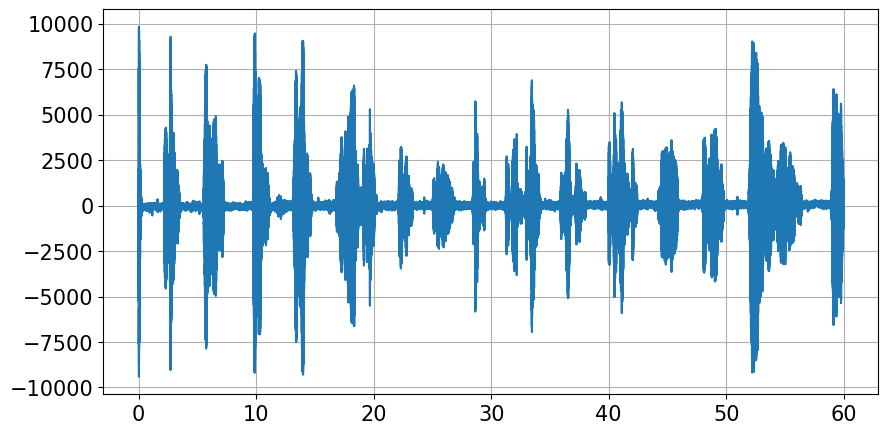

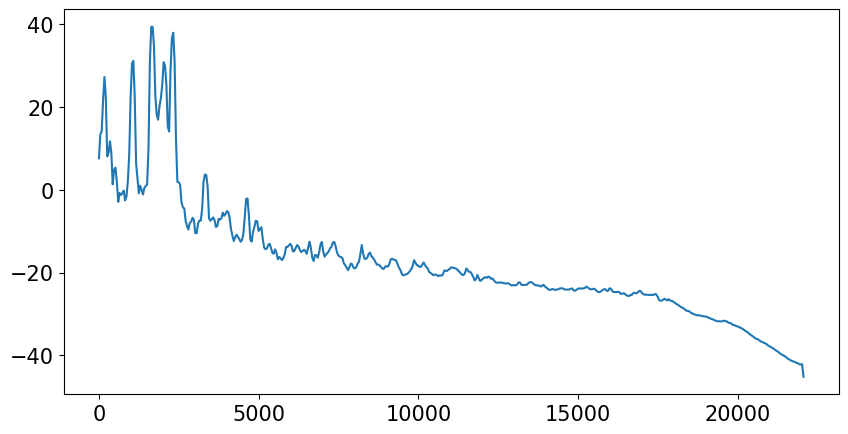

In [5]:
root="./data/"        # root directory of data
test=1

if test==0:
    HH="D1382ae"            # prefix of directory ("D") + Serial number of recorder in HEX ("1382ae")
    TSEL=[2023,3,8,12,39];  # time of first file (year,month,day,hour,minute)
elif test==1:
    HH="D0baa7e"            # prefix of directory ("D") + Serial number of recorder in HEX ("0baa7e")
    TSEL=[2023,4,7,17,40];  # time of first file (year,month,day,hour,minute)

N_num=1                 # number of files/minutes starting from TSEL

isel=TSEL.copy()
for jn in range(N_num):
    fileNames=mDir(root,HH,isel)
    for fileName in fileNames:
        print('File name: ',fileName)
        if os.path.getsize(fileName)==0: continue
        xx,nch,fs,cp,sh,vers,SerNum,recTimeStamp = loadData(fileName)
        print(nch,fs,cp,sh,vers,SerNum,recTimeStamp)
        #
        if (vers>=10) & (vers<20):
            if cp==0:
                datx=np.frombuffer(xx[128:],np.int16)
            elif cp==1:
                datx,td1,td2=getData16(xx)
        elif vers==20:
            if cp==0:
                datx=np.frombuffer(xx[128:],np.int32)
            elif cp==1:
                datx,td1,td2=getData32(xx)
        #
        # correct for bias
        bias=np.mean(datx)
        datx = datx - bias
        # time axis
        tt=np.arange(len(datx))/fs
        if 1:
            plt.plot(tt,datx)
            plt.grid(True)
            plt.show()

            f,Pxxf = signal.welch(datx,fs,nperseg=1024,axis=0)
            fig=plt.figure('figure.figsize',[10, 5])
            plt.plot(f,10*np.log10(Pxxf));
            plt.show()

    #update time vector for next minue
    t1=datetime(isel[0],isel[1],isel[2],isel[3],isel[4],0)+ timedelta(minutes=1)
    isel=np.array(t1.timetuple())[:5]


### Spectrogram

1 44100 1 12 20 764542 20230407_174000 
1


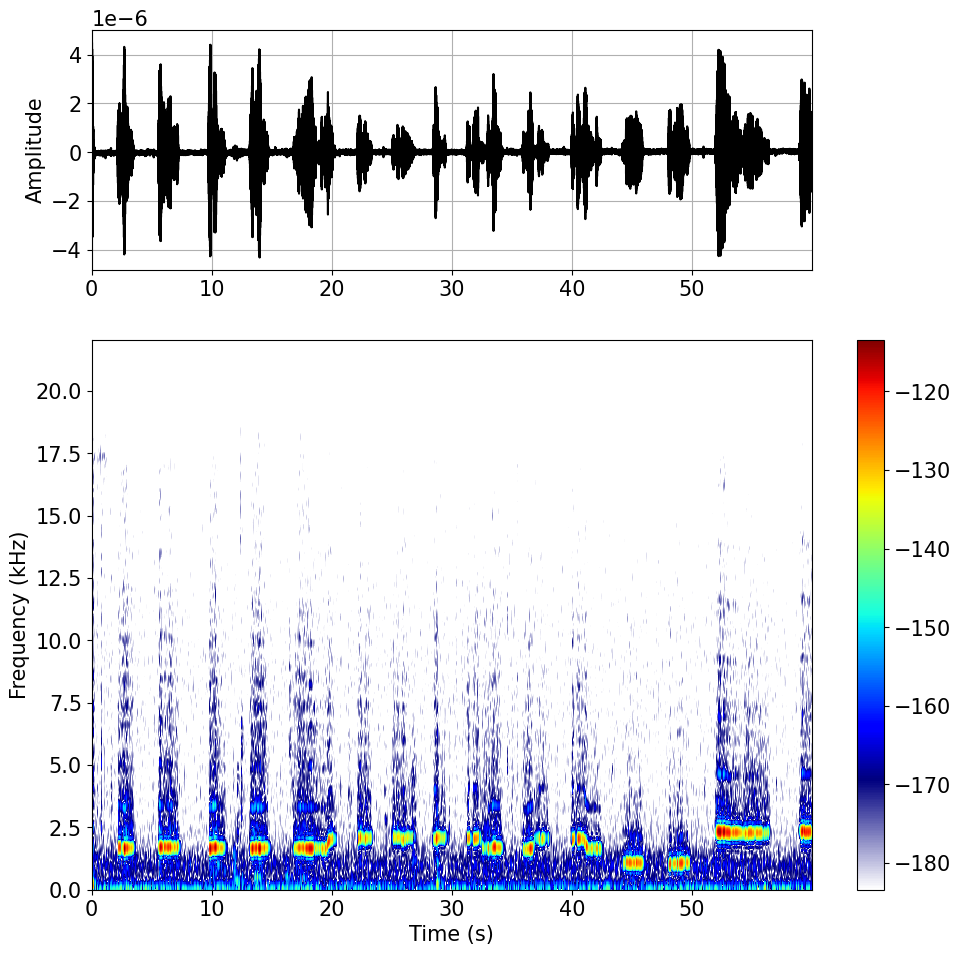

In [6]:
xx,nch,fs,cp,sh,vers,SerNum,recTimeStamp = loadData(fileName)
print(nch,fs,cp,sh,vers,SerNum,recTimeStamp)

if (vers>=10) & (vers<20):
    scl=2**15
    if cp==0:
        datx=np.frombuffer(xx[128:],np.int16)
    elif cp==1:
        datx,td1,td2=getData16(xx)
elif vers>=20:
    scl=2**31
    if cp==0:
        datx=np.frombuffer(xx[128:],np.int32)
    elif cp==1:
        datx,td1,td2=getData32(xx)

# correct for bias
bias=np.mean(datx)
datx = datx - bias
# time axis
tt=np.arange(len(datx))/fs
dat1=datx

nw=256
nfft=1024
yy=datx/scl
f, t, Zxx = signal.stft(yy, fs,axis=0, nperseg=nw, nfft=nfft)
zz=20*np.log10(np.abs(np.squeeze(Zxx))) 
zm=np.max(zz)
[nf,nt]=np.shape(zz)

cm1=plt.cm.jet
cm2=plt.cm.viridis
cm3=mcmap()
cmx=cm3

# prepare plot
fig = plt.figure("figure.figsize",[10,10])
# for time series
ax1 = plt.axes([0.15, 0.71, 0.72, 0.24])
# for spectrogram
ax2 = plt.axes([0.15, 0.09, 0.9, 0.55], sharex=ax1)

# plot time series
p1 = ax1.plot(tt,yy,"k")
ax1.set_xlim(tt[0],tt[-1])
ax1.set_ylabel("Amplitude")
ax1.grid(True)

# plot spectrogram
im = ax2.imshow(zz, 
                extent=(0,(nt-1)/fs*nw/2,0,fs/2000),
                origin='lower', cmap=cmx, clim=(zm-70,zm),
                interpolation='nearest', aspect='auto')
ext = im.get_extent()
cbar = plt.colorbar(im, orientation='vertical',ax=ax2)
ax2.set_ylabel("Frequency (kHz)")
ax2.set_xlabel("Time (s)");
plt.show();

### Playing audio data

In [7]:
# remove # from next line to play sound
#sd.play(yy, 44100)

## Visualize file

1 44100 1 12 20 764542 20230407_174000 
first block


c:\Users\zimme\jupyter\microPAM\microPAM_utils.py:331: RuntimeWarning: overflow encountered in scalar subtract
  ndx=nd1-nch


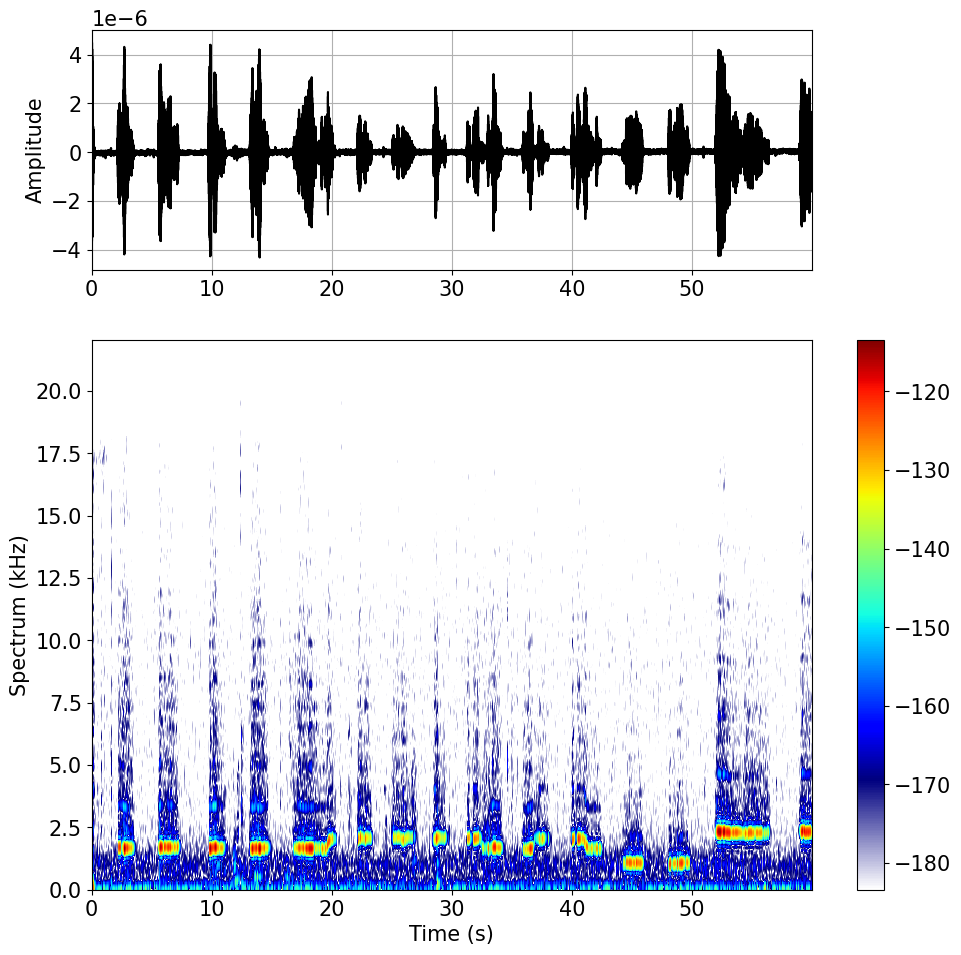

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

import sounddevice as sd

# use local microPAM library
import microPAM_utils as upam

fileName='./data/D0baa7e_20230407/17/F_174000.bin'

dat,ta,to,td1,td2,fs,sh,SerNum=upam.loadAcoustics_o(fileName)
#
# correct for bias
bias=np.mean(dat)
dat = dat - bias
# time axis
tt=np.arange(len(dat))/fs
#
# spectrogram
nw=256
nfft=1024
yy=dat[:,0]
fz, tz, Zxx = signal.stft(yy, fs,axis=0, nperseg=nw, nfft=nfft)
zz=20*np.log10(np.abs(Zxx)) 
#
# prepare plot
def plot_data(tt,yy,tz,fz,zz):
    cm1=plt.cm.jet
    cm2=plt.cm.viridis
    cm3=upam.mcmap(256)
    cmx=cm3
    zm=np.max(zz)
    #
    fig = plt.figure("figure.figsize",[10,10])
    # for time series
    ax1 = plt.axes([0.15, 0.71, 0.72, 0.24])
    # for spectrogram
    ax2 = plt.axes([0.15, 0.09, 0.90, 0.55], sharex=ax1)
    #
    # plot time series
    p1 = ax1.plot(tt,yy,"k")
    ax1.set_xlim(tt[0],tt[-1])
    ax1.set_ylabel("Amplitude")
    ax1.grid(True)
    #
    # plot spectrogram
    im = ax2.imshow(zz, 
                    extent=(tz[0],tz[-1],fz[0]/1000,fz[-1]/1000),
                    origin='lower', cmap=cmx, clim=(zm-70,zm),
                    interpolation='nearest', aspect='auto')
    cbar = plt.colorbar(im, orientation='vertical',ax=ax2)
    ax2.set_ylabel("Spectrum (kHz)")
    ax2.set_xlabel("Time (s)")
    plt.show()

plot_data(tt,yy,tz,fz,zz)

if 0:
    sd.play(dat/np.max(datx)/2,fs)

## Redesign of ILAC (Integer-Lossless-Acoustic-Compression) decompression

./data/D0baa7e_20230407/17/F_174000.bin
20
(2644224, 1) 44100 764542 20230407_174000 
1680889173.756873 = 2023-04-07 19:39:33.756873 ; 1680882000.0 = 20230407_174000 


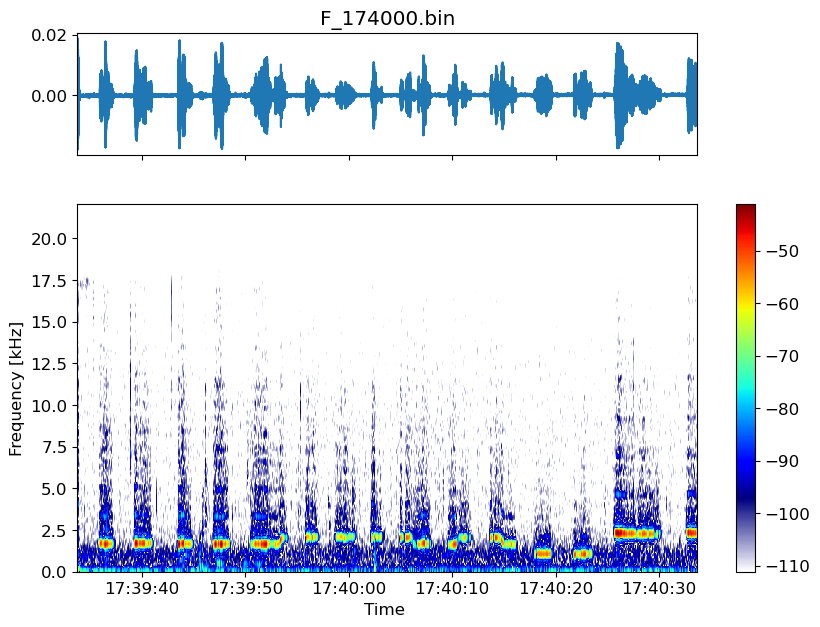

In [9]:
#
if 1:
    fileName='./data/D0baa7e_20230407/17/F_174000.bin'
else:
    from tkinter import filedialog
    fileName = filedialog.askopenfilename(initialdir="./")

print(fileName)
#
td,dat,fs,SerNum,recTimeStamp=loadAcoustics(fileName)
print(dat.shape,fs,SerNum,recTimeStamp)

dat = dat-dat.mean()
#
nwin = 256
nstep = nwin//2
nfft = 1024
scaling = 'spectrum'
#scaling = 'density'
if 1:
    fx,tx,px = spectrogram(dat,fs,nfft,nwin,nstep,scaling)
else:
    nw=256
    nfft=1024
    fx, tx, px = signal.stft(dat, fs,axis=0, nperseg=nw, nfft=nfft)
    px=px[:,0,:]

from datetime import datetime
to=td[0]
print(to,'=',datetime.fromtimestamp(to),';',str2seconds(recTimeStamp),'=',recTimeStamp)

import os
fig=plotAcoustics(td,dat,to+tx,fx,px,os.path.basename(fileName))

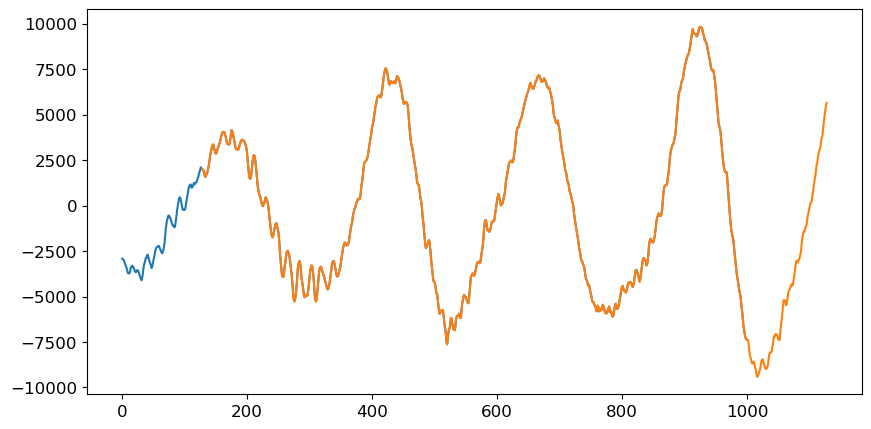

In [10]:
# compare old and new ILAC decompression
plt.plot(np.arange(1000),(dat[:1000]-dat.mean())*2**19) # undue scaling
plt.plot(128+np.arange(1000),dat1[:1000])
plt.show()

In [11]:
# check wav file headers (original and custom)
fileName='C:\\Users\\zimme\\Desktop\\microPAM\\data\\F20241221_083540.wav'
fileName='C:\\Users\\zimme\\Desktop\\F20241123_142300.wav'
fileName='C:\\Users\\zimme\\Desktop\\3M_ch4_35-40.wav'

xx = np.fromfile(fileName, dtype='uint32',count=128)
print(xx[0].tobytes().decode())
print(xx[1])
print(xx[2].tobytes().decode())
print(xx[3].tobytes().decode())
print(xx[4])
print(xx[9].tobytes().decode())
print(xx[10])
if xx[9].tobytes().decode() == 'info':
    print(xx[126].tobytes().decode())
    print(xx[127])


RIFF
28800036
WAVE
fmt 
16
data
28800000


1 44100 1 14 10 1278638 20230308_123903 
(2486016, 1)


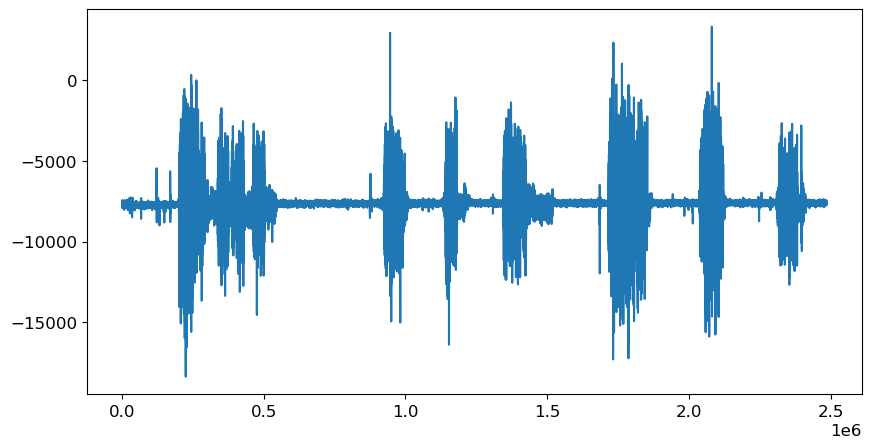

In [12]:
#decoding 16-bit compressed data

fname='.\\data\\D1382ae_20230308\\12\\F_123903.bin'

xx,nch,fs,cp,sh,vers,SerNum,recTimeStamp=loadData(fname)
print(nch,fs,cp,sh,vers,SerNum,recTimeStamp)

nblock=nch*128
yy=decodeInit(xx,nch,128)
#printHex(yy[:10,:30])

dat2=decode16(yy,nch,128)
dat2=dat2.reshape(-1,nch).astype('float')
print(dat2.shape)

plt.plot(dat2)
plt.show()

20


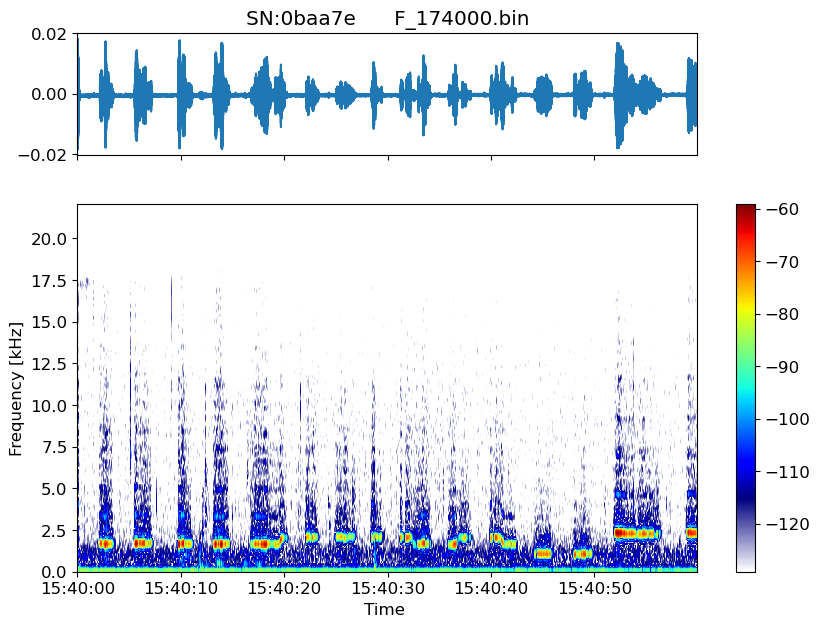

In [13]:
fname='./data/D0baa7e_20230407/17/F_174000.bin'
upam.showAcoustics(fname)

In [14]:
# to play audio
if 0:
    fname='./data/D0baa7e_20230407/17/F_174000.bin'
    upam.playAcoustics(fname,0.5,0)

In [15]:
# to stop audio if playing
sd.stop()

In [16]:
import microPAM_utils as upam
help(upam.loadAcoustics)

Help on function loadAcoustics in module microPAM_utils:

loadAcoustics(fileName)
    load microPAM acoustic data (bin or wav)
    td,dat,fs,SerNum,recTimeStamp = loadAcoustics(fileName)

